<a href="https://colab.research.google.com/github/Yonasafom/DeepLearningSpecialization-/blob/main/DSEAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install stellargraph

In [50]:
!git clone https://github.com/facebookresearch/SEAL_OGB.git
!git clone https://github.com/matthew-hirn/magnet.git
!git clone https://github.com/XitongZhang1994/SimpleMagNet.git

fatal: destination path 'SEAL' already exists and is not an empty directory.
fatal: destination path 'SEAL_OGB' already exists and is not an empty directory.
fatal: destination path 'magnet' already exists and is not an empty directory.
fatal: destination path 'SimpleMagNet' already exists and is not an empty directory.


In [51]:
# Mount your local google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#### Orginal directed datasets. 
We can get the directed **citation graphs** using the **"load_citation_link"** function which is avialable in the **citation **file. It takes the raw .npz file as an argument. 

The directed version of WebKB, WikipediaNetwork and WikiCS  can be obtained using "load_func" function. Which is available in the Edge_sparseMagnet file. It takes the undirected  torch_geometric.datasets version as an argument.

#### **Postive and negative Edge samples for Link prediction task.**

To do Link prediciton task, directd postive and negative edges are sampled from the original directed graph. To get the directed postive and negative samples for train, val and test with their respective labels can taken from  "generate_dataset_2class" function in edge_data file of magnet with some modification is used. Eedge index and probablity of sampling is given as an argument.

In [53]:
# # Initial Data processing 
from hermitian import *
from edge_data import * # generate_dataset_2class, in_out_degree, link_prediction_evaluation
from preprocess import * # to_edge_dataset_sparse, load_syn
from Citation import load_citation_link

In [54]:
#Original directed data
dataset = torch.load("/content/DSEAL/WebKB/Cornell/cornell/processed/data.pt")
#dataset = torch.load("WebKB/Cornell/cornell/data.pt")

if 'dataset' in locals():
  data = dataset[0]
  edge_index = data.edge_index

# Get Edge based splitting for link prediction  
datasets = generate_dataset_2class(edge_index, data, splits = 1 , test_prob = 0.3)
torch.save(datasets, "/content/DSEAL/datasets_edge_2class.pt")

# print(datasets[0]['graph'] ["x"] )
# datasets = generate_dataset_3class(edge_index, size, save_file, splits = 10, probs = args.split_prob, task=args.task, label_dim=args.num_class_link)

In [55]:
datasets[0].keys()

dict_keys(['graph', 'undirected', 'train_pos_neg', 'train_pair_label', 'val_pos_neg', 'val_pair_label', 'test_pos_neg', 'test_pair_label'])

In [56]:
!cd SEAL_OGB/
#  os.mkdir("DSEAL_data")

### K hop subgraphs for the sampled postive and negative edges.

K hop enclosing subgraphs with for the train, val and test of the directed edges can be extracted using the **extract_enclosing_subgraphs** function available in the **utils** file of the SEAL_OGB. The edges, the adjacecy matrix of the original graph and type of labeling trick is provided as an argument.

In [57]:
# Subgraph Extraction Imports

import argparse
import time
import os, sys
import os.path as osp
from shutil import copy
import copy as cp
from tqdm import tqdm
import pdb

import numpy as np
from sklearn.metrics import roc_auc_score
import scipy.sparse as ssp
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from torch_sparse import coalesce
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
from torch_geometric.utils import to_networkx, to_undirected

# from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)
# from utils import Logger
from SEAL_OGB.utils import *
# from models import *

In [58]:
class SEALDataset(InMemoryDataset):
    def __init__(self, root, data, pos_edge, neg_edge, num_hops, percent=100, split='train', 
                 use_coalesce=False, node_label='drnl', ratio_per_hop=1.0, 
                 max_nodes_per_hop=None, directed=True):
        self.data = data
        self.pos_edge = pos_edge
        self.neg_edge = neg_edge
        # self.split_edge = split_edge
        self.num_hops = num_hops
        self.percent = int(percent) if percent >= 1.0 else percent
        self.split = split
        self.use_coalesce = use_coalesce
        self.node_label = node_label
        self.ratio_per_hop = ratio_per_hop
        self.max_nodes_per_hop = max_nodes_per_hop
        self.directed = directed
        super(SEALDataset, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])
        # self.links = []

    @property
    def processed_file_names(self):
        if self.percent == 100:
            name = 'SEAL_{}_data'.format(self.split)
        else:
            name = 'SEAL_{}_data_{}'.format(self.split, self.percent)
        name += '.pt'
        return [name]

 
    
    def process(self):
        # pos_edge, neg_edge = get_pos_neg_edges(self.split, self.split_edge, 
        #                                        self.data.edge_index, 
        #                                        self.data.num_nodes, 
        #                                        self.percent)
        
        
        # self.links = torch.cat([pos_edge, neg_edge], 1).t().tolist()

        if self.use_coalesce:  # compress mutli-edge into edge with weight
            self.data.edge_index, self.data.edge_weight = coalesce(
                self.data.edge_index, self.data.edge_weight, 
                self.data.num_nodes, self.data.num_nodes)

        if 'edge_weight' in self.data:
            edge_weight = self.data.edge_weight.view(-1)
        else:
            edge_weight = torch.ones(self.data.edge_index.size(1), dtype=int)
        A = ssp.csr_matrix(
            (edge_weight, (self.data.edge_index[0], self.data.edge_index[1])), 
            shape=(self.data.num_nodes, self.data.num_nodes)
        )

        if self.directed:
            A_csc = A.tocsc()
        else:
            A_csc = None
        
        #sample
        pos = pos_edge.T[0:10].T
        neg = neg_edge.T[0:10].T
        pairs = torch.cat((pos, neg), axis=-1)
        torch.save(pairs, "/content/test_pairs.pt")

        # Extract enclosing subgraphs for pos and neg edge
        pos_list = extract_enclosing_subgraphs(
            self.pos_edge, A, self.data.x, 1, self.num_hops, self.node_label, 
            self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc)
        
        neg_list = extract_enclosing_subgraphs(
            self.neg_edge, A, self.data.x, 0, self.num_hops, self.node_label, 
            self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc)
        
        # pairs, label = label_pairs_gen(pos, neg)
        # np.save('/content/pos_edge.npy', pos, allow_pickle=True)
        # np.save('/content/neg_edge.npy', neg, allow_pickle=True)
        # torch.save(pos, "/content/pos_edge.pt")

        dataset_truth = {}
        torch.save(self.collate(pos_list + neg_list), self.processed_paths[0])
        del neg_list, pos_list

In [59]:
# Subgraph extraction settings
parser = argparse.ArgumentParser(description='(SEAL)')
parser.add_argument('--num_hops', type=int, default=1)
parser.add_argument('--ratio_per_hop', type=float, default=1.0)
parser.add_argument('--max_nodes_per_hop', type=int, default=None)
parser.add_argument('--node_label', type=str, default='drnl', 
                    help="which specific labeling trick to use")
parser.add_argument('--use_feature', action='store_true', 
                    help="whether to use raw node features as GNN input")
parser.add_argument('--use_edge_weight', action='store_true', 
                    help="whether to consider edge weight in GNN")

args = parser.parse_args([])

#
use_coalesce = False 

args.num_workers = 0

directed = True
args.dynamic_train = False
args.dynamic_val  = False

args.dynamic_test = False
args.num_hops = 2
directed = True

#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

####Overhere, we are getting the PyG in memory dataset for  for all the sampled linkes of the train, val and test as a list of PyG dataset. At this point we are not fellowing the dynamic extracting process.

In [60]:
#Data
data = datasets[0]['graph']['data']
!mkdir "DSEAL_data"
path = "DSEAL_data"

#Training SEAL dataset
pos_edge = datasets[0]['train_pos_neg']['pos']
neg_edge = datasets[0]['train_pos_neg']['neg']

data.edge_index = pos_edge # split_edge['train']['edge'].t()
dataset_class = 'SEALDynamicDataset' if args.dynamic_train else 'SEALDataset'
train_dataset = eval(dataset_class)(
    path, 
    data,
    pos_edge,
    neg_edge, 
    num_hops=args.num_hops, 
    percent=100, 
    split='train', 
    use_coalesce=use_coalesce, 
    node_label=args.node_label, 
    ratio_per_hop=args.ratio_per_hop, 
    max_nodes_per_hop=args.max_nodes_per_hop, 
    directed=directed, 
) 


#Val SEAL dataset
pos_edge =  datasets[0]['val_pos_neg']['pos'] 
neg_edge = datasets[0]['val_pos_neg'] ['neg'] 
dataset_class = 'SEALDynamicDataset' if args.dynamic_val else 'SEALDataset'
val_dataset = eval(dataset_class)(
    path, 
    data,
    pos_edge,
    neg_edge, 
    num_hops=args.num_hops, 
    percent=100, 
    split='valid', 
    use_coalesce=use_coalesce, 
    node_label=args.node_label, 
    ratio_per_hop=args.ratio_per_hop, 
    max_nodes_per_hop=args.max_nodes_per_hop, 
    directed=directed,

)

# Test SEAL dataset

pos_edge =  datasets[0]['test_pos_neg']['pos'] 
neg_edge = datasets[0]['test_pos_neg'] ['neg'] 
pos_edge = pos_edge.to(device)
neg_edge = neg_edge.to(device)
dataset_class = 'SEALDynamicDataset' if args.dynamic_test else 'SEALDataset'
test_dataset = eval(dataset_class)(
    path, 
    data,
    pos_edge,
    neg_edge, 
    num_hops=args.num_hops, 
    percent=100, 
    split='test', 
    use_coalesce=use_coalesce, 
    node_label=args.node_label, 
    ratio_per_hop=args.ratio_per_hop, 
    max_nodes_per_hop=args.max_nodes_per_hop, 
    directed=directed,

)

mkdir: cannot create directory ‘DSEAL_data’: File exists


### Sub graph claassification 
Using the Extracted subgraphs of train, val and test we perform subgraph classification. The subgraph referes to each link in the postive and negative links. The Labeling trick added, makes each subgraph's structural representation different from the rest of the subgraphs by providing positional encoding. This avoids the isomorphism issue of GNN for multiset representation learning, if the nodes get their representation learning independently.

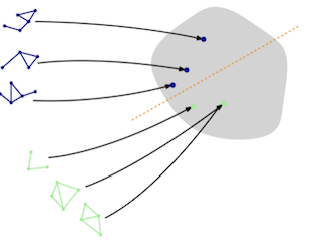

###Here We are trying to fork Magnet model for subgraph classification 

In [61]:
# Magnet: parameter setting 

def parse_args():
    parser = argparse.ArgumentParser(description="link prediction of MagNet")
    parser.add_argument('--log_root', type=str, default='../logs/', help='the path saving model.t7 and the training process')
    parser.add_argument('--log_path', type=str, default='test', help='the path saving model.t7 and the training process, the name of folder will be log/(current time)')
    parser.add_argument('--data_path', type=str, default='../dataset/data/tmp/', help='data set folder, for default format see dataset/cora/cora.edges and cora.node_labels')
    parser.add_argument('--dataset', type=str, default='', help='data set selection')
    
    
    parser.add_argument('--split_prob', type=lambda s: [float(item) for item in s.split(',')], default="0.15,0.05", help='random drop for testing/validation/training edges (for 3-class classification only)')
    parser.add_argument('--task', type=int, default=2, help='2: 2-class classification 3: 3-class classification')
    
    parser.add_argument('--epochs', type=int, default=1500, help='training epochs')
    parser.add_argument('--num_filter', type=int, default=4, help='num of filters')
    parser.add_argument('-not_norm', '-n', action='store_false', help='if use normalized laplacian or not, default: yes')

    parser.add_argument('--method_name', type=str, default='MagNet_Edge', help='method name')
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--q', type=float, default=0, help='q value for the phase matrix')
    parser.add_argument('--K', type=int, default=1, help='K for cheb series')
    parser.add_argument('--layer', type=int, default=2, help='how many layers of gcn in the model, only 1 or 2 layers.')

    parser.add_argument('--num_workers', type=int, default=0, 
                    help="number of workers for dynamic mode; 0 if not dynamic")

    parser.add_argument('--dropout', type=float, default=0.5, help='dropout prob')
    parser.add_argument('--debug', '-D', action='store_true', help='debug mode')
    parser.add_argument('--num_class_link', type=int, default=2,
                        help='number of classes for link direction prediction(2 or 3).')

    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
    parser.add_argument('--l2', type=float, default=5e-4, help='l2 regularizer')
    return parser.parse_args([])

### Mini-batching of the subgraphs

For full GPU utilization the subgraphs get batched before inputing them into the GNN. 

PyG acheive baching by stacking the adjacency matrices in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features get concatenated in the node dimension.

PyG use DataLoader classes for batching. https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader)

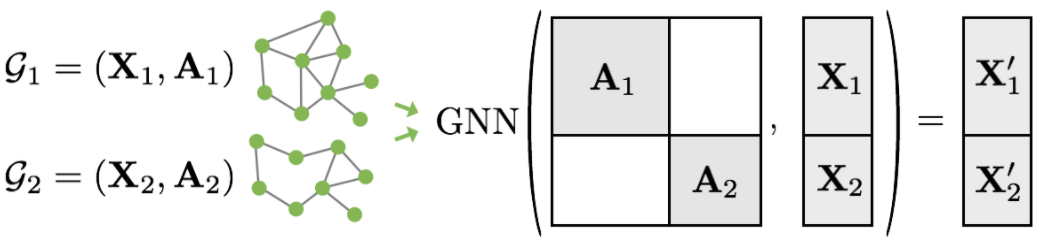

In [62]:
# Dataloader
args = parse_args()

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, 
                      shuffle=True, num_workers=args.num_workers)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, 
                    num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, 
                      num_workers=args.num_workers)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [63]:
# This are some external files used during classification 

import torch, math
import torch.nn as nn
import torch.nn.functional as F
from torch_sparse import SparseTensor
from torch.nn import (ModuleList, Linear, Conv1d, MaxPool1d, Embedding, ReLU, 
                      Sequential, BatchNorm1d as BN)
from torch_geometric.nn import (GCNConv, SAGEConv, GINConv, 
                                global_sort_pool, global_add_pool, global_mean_pool)

import numpy as np
import pickle as pk
from scipy import sparse
import torch.optim as optim
from datetime import datetime
import os, time, argparse, csv
from collections import Counter
import torch.nn.functional as F
from torch_sparse import SparseTensor
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.datasets import WebKB, WikipediaNetwork, WikiCS
from torch_geometric.data.batch import *

In [75]:
#The MagConv taken from magnet which need to be forked for graph classification task

def process(mul_L_real, mul_L_imag, weight, X_real, X_imag):
    data = torch.spmm(mul_L_real, X_real)
    real = torch.matmul(data, weight) 
    data = -1.0*torch.spmm(mul_L_imag, X_imag)
    real += torch.matmul(data, weight) 
    
    data = torch.spmm(mul_L_imag, X_real)
    imag = torch.matmul(data, weight)
    data = torch.spmm(mul_L_real, X_imag)
    imag += torch.matmul(data, weight)
    return torch.stack([real, imag])

class MagConv(nn.Module):
    """
    The MagNet convolution operation.

    :param in_c: int, number of input channels.
    :param out_c: int, number of output channels.
    :param K: int, the order of Chebyshev Polynomial.
    :param L_norm_real, L_norm_imag: normalized laplacian of real and imag
    """
    def __init__(self, in_c, out_c, K, bias=True):
        super(MagConv, self).__init__()


        self.weight = nn.Parameter(torch.Tensor(K + 1, in_c, out_c))  # [K+1, 1, in_c, out_c]

        stdv = 1. / math.sqrt(self.weight.size(-1))
        self.weight.data.uniform_(-stdv, stdv)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, out_c))
            nn.init.zeros_(self.bias)
        else:
            self.register_parameter("bias", None)

    def forward(self, data, L_norm_real, L_norm_imag):

        """
        :param inputs: the input data, real [B, N, C], img [B, N, C]
        :param L_norm_real, L_norm_imag: the laplace, [N, N], [N,N]
        """
        L_norm_real, L_norm_imag = L_norm_real, L_norm_imag

        # list of K sparsetensors, each is N by N
        self.mul_L_real = L_norm_real   # [K, N, N]
        self.mul_L_imag = L_norm_imag   # [K, N, N]
        X_real, X_imag = data[0], data[1]

        real = 0.0
        imag = 0.0

        future = []
        for i in range(len(self.mul_L_real)): # [K, B, N, D]
            future.append(torch.jit.fork(process, 
                            self.mul_L_real[i], self.mul_L_imag[i], 
                            self.weight[i], X_real, X_imag))
        result = []
        for i in range(len(self.mul_L_real)):
            result.append(torch.jit.wait(future[i]))
        result = torch.sum(torch.stack(result), dim=0)

        real = result[0]
        imag = result[1]
        return real + self.bias, imag + self.bias


class complex_relu_layer(nn.Module):
    def __init__(self, ):
        super(complex_relu_layer, self).__init__()
    
    def complex_relu(self, real, img):
        mask = 1.0*(real >= 0)
        return mask*real, mask*img

    def forward(self, real, img=None):
        # for torch nn sequential usage
        # in this case, x_real is a tuple of (real, img)
        if img == None:
            img = real[1]
            real = real[0]

        real, img = self.complex_relu(real, img)
        return real, img


In [65]:
# For node classification task

class MagNet(nn.Module):
    def __init__(self, in_c, L_norm_real, L_norm_imag, num_filter=2, K=2, label_dim=2, layer=2, dropout=False):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.
        :param K: for cheb series
        :param L_norm_real, L_norm_imag: normalized laplacian
        """
        super(MagNet, self).__init__()

        activation_func = complex_relu_layer

        chebs = [MagConv(in_c=in_c, out_c=num_filter, K=K, L_norm_real=L_norm_real, L_norm_imag=L_norm_imag)]
        chebs.append(activation_func())

        for i in range(1, layer):
            chebs.append(MagConv(in_c=num_filter, out_c=num_filter, K=K, L_norm_real=L_norm_real, L_norm_imag=L_norm_imag))
            chebs.append(activation_func())

        self.Chebs = torch.nn.Sequential(*chebs)

        last_dim = 2  
        self.Conv = nn.Conv1d(num_filter*last_dim, label_dim, kernel_size=1)        
        self.dropout = dropout

    def forward(self, real, imag, L_norm_real, L_norm_imag, z_emb, batch):
        real, imag = self.Chebs((real, imag), L_norm_real=L_norm_real, L_norm_imag=L_norm_imag)
        x = torch.cat((real, imag), dim = -1)
        
        if self.dropout > 0:
            x = F.dropout(x, self.dropout, training=self.training)

        x = x.unsqueeze(0)
        x = x.permute((0,2,1))
        x = self.Conv(x)
        x = F.log_softmax(x, dim=1)
        return x

In [73]:
# Magnet link prediction. We need to fork it to subgraph classification 


class MagNet_Edge(nn.Module):
    def __init__(self, in_c, num_filter=2, K=2, label_dim = 2, layer = 2, dropout = False):
        super(MagNet_Edge, self).__init__()

        # self.z_emb = z_emb
        activation_func = complex_relu_layer

        self.z_embedding = Embedding(1000, in_c)

        chebs = [MagConv(in_c=in_c, out_c=num_filter, K=K)]
        chebs.append(activation_func())

        for i in range(1, layer):
            chebs.append(MagConv(in_c=num_filter, out_c=num_filter, K=K))
            chebs.append(activation_func())
        self.Chebs = torch.nn.Sequential(*chebs)
        
        last_dim = 2
        self.linear = nn.Linear(num_filter*last_dim*2, label_dim)     
        self.dropout = dropout
        

    def forward(self, real, imag, L_img , L_real, z_emb, batch):
        z_emb = self.z_embedding(z_emb)
        if z_emb.ndim == 3:  # in case z has multiple integer labels
            z_emb = z_emb.sum(dim=1)
        # if self.use_feature and x is not None:
        #     x = torch.cat([z_emb, x.to(torch.float)], 1)
        # else:
        # x = z_emb
        z_emb = global_add_pool(z_emb, batch)
        # z_emb = F.relu(self.lin1(z_emb))

        real, imag = self.Chebs((real, imag), L_real, L_img)

        x = torch.cat((real[index[:,0]], real[index[:,1]], imag[index[:,0]], imag[index[:,1]]), dim = -1)
        x = global_add_pool(x, batch)
        x = torch.cat([z_emb, x.to(torch.float)], 1)
        # print(x.shape)
        if self.dropout > 0:
            x = F.dropout(x, self.dropout, training=self.training)

        x = self.linear(x)
        # print(x.shape)
        x = F.log_softmax(x, dim=1)
        
        return x

In [67]:
# methods taken from magnet for processing the laplacian and edge features 

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

# in-out degree calculation
def in_out_degree(edge_index, size):
    A = coo_matrix((np.ones(len(edge_index)), (edge_index[:,0], edge_index[:,1])), shape=(size, size), dtype=np.float32).tocsr()
    out_degree = np.sum(A, axis = 0).T
    in_degree = np.sum(A, axis = 1)
    degree = torch.from_numpy(np.c_[in_degree, out_degree]).float()
    return degree


def to_edge_dataset_sparse(q, edge_index, K, data_split, size, root='../dataset/data/tmp/', laplacian=True, norm=True, max_eigen = 2.0, gcn_appr = False):
    f_node, e_node = edge_index[0], edge_index[1]
    L = hermitian_decomp_sparse(f_node, e_node, size, q, norm=True, laplacian=laplacian, max_eigen = 2.0, gcn_appr = gcn_appr)
    multi_order_laplacian = cheb_poly_sparse(L, K)

    return multi_order_laplacian


# Node features and laplacian 
def geometric_dataset_sparse(q, K, data, load_only = False, save_pk = True, laplacian = True, gcn_appr = False):
   

    size = data.y.size(-1)
    #adj = torch.zeros(size, size).data.numpy().astype('uint8')
    #adj[dataset[0].edge_index[0], dataset[0].edge_index[1]] = 1

    f_node, e_node = data.edge_index[0], data.edge_index[1]

    label = data.y.data.numpy().astype('int')
    # X = data.x.data.numpy().astype('float32')
    # train_mask = data.train_mask.data.numpy().astype('bool_')
    # val_mask = data.val_mask.data.numpy().astype('bool_')
    # test_mask = data.test_mask.data.numpy().astype('bool_')

    # if load_only:
    #     return X, label, train_mask, val_mask, test_mask
    
    try:
        L = hermitian_decomp_sparse(f_node, e_node, size, q, norm=True, laplacian=laplacian, 
            max_eigen = 2.0, gcn_appr = gcn_appr, edge_weight = data.edge_weight)
    except AttributeError:
        L = hermitian_decomp_sparse(f_node, e_node, size, q, norm=True, laplacian=laplacian, 
            max_eigen = 2.0, gcn_appr = gcn_appr, edge_weight = None)

    multi_order_laplacian = cheb_poly_sparse(L, K)
    return X, label,  multi_order_laplacian

In [ ]:
datasets[0].keys()

dict_keys(['graph', 'undirected', 'train_pos_neg', 'train_pair_label', 'val_pos_neg', 'val_pair_label', 'test_pos_neg', 'test_pair_label'])

In [ ]:
# Test hermitian laplacian loader test
for data in train_loader:
  print(data.z)
  edges = data.edge_index
  i = 0
  size = torch.max(data.edge_index).item()+1
  L = to_edge_dataset_sparse(args.q, edges, args.K, i, size, root=args.data_path+args.dataset, 
                            laplacian=True, norm=args.not_norm, gcn_appr = False) 

In [86]:
# initialize model 

data = datasets[0]['graph']['data']
edge_index  = data.edge_index

# get feature
X_img = in_out_degree(edges, size).to(device)
X_real = X_img.clone()

model = MagNet_Edge(X_real.size(-1), K = args.K, label_dim = args.num_class_link, layer = args.layer,
                        num_filter = args.num_filter, dropout=args.dropout)
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

In [88]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.

         data = data.to(device)
         opt.zero_grad()
         
         edges = data.edge_index
         
         size = torch.max(data.edge_index).item()+1
         i = 0
         L = to_edge_dataset_sparse(args.q, edges, args.K, i, size, root=args.data_path+args.dataset, 
                            laplacian=True, norm=args.not_norm, gcn_appr = False) 

         # convert dense laplacian to sparse matrix
         L_img = []
         L_real = []
         for i in range(len(L)):
              L_img.append( sparse_mx_to_torch_sparse_tensor(L[i].imag).to(device) )
              L_real.append( sparse_mx_to_torch_sparse_tensor(L[i].real).to(device) )


        # get feature
         X_img = in_out_degree(edges, size).to(device)
         X_real = X_img.clone()

         train_loss, train_acc = 0.0, 0.0
         model.train()
         z_emb = data.z
         out = model(X_real, X_img,  L_img , L_real, z_emb, data.batch)
        
         train_loss = F.nll_loss(out, y_train)
         pred_label = out.max(dim = 1)[1]            
         train_acc  = acc(pred_label, y_train)
        
         opt.zero_grad()
         train_loss.backward()
         opt.step()


def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         opt.zero_grad()
         
         edges = data.edge_index
         size = torch.max(data.edge_index).item()+1
         i = 0
         L = to_edge_dataset_sparse(args.q, edges, args.K, i, size, root=args.data_path+args.dataset, 
                            laplacian=True, norm=args.not_norm, gcn_appr = False) 

         # convert dense laplacian to sparse matrix
         L_img = []
         L_real = []
         for i in range(len(L)):
              L_img.append( sparse_mx_to_torch_sparse_tensor(L[i].imag).to(device) )
              L_real.append( sparse_mx_to_torch_sparse_tensor(L[i].real).to(device) )


        # get feature
         X_img = in_out_degree(edges, size).to(device)
         X_real = X_img.clone()

         train_loss, train_acc = 0.0, 0.0
         model.train()
         z_emb = data.z
         out = model(X_real, X_img,  L_img , L_real, z_emb, data.batch)
         pred = out.max(dim = 1)[1]

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


<IPython.core.display.Javascript object>

In [ ]:
for epoch in range(1, 5):
    train()
    # train_acc = test(train_loader)
    # test_acc = test(test_loader)
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Magnet Baseline

In [ ]:
import numpy as np
import pickle as pk
import torch.optim as optim
from datetime import datetime
import os, time, argparse, csv
from collections import Counter
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.datasets import WebKB, WikipediaNetwork, WikiCS
from torch_geometric.utils import to_undirected

# internal files
from layer.sparse_magnet import *
from utils.edge_data import * # generate_dataset_2class, in_out_degree, link_prediction_evaluation
from utils.preprocess import to_edge_dataset_sparse, load_syn
from utils.save_settings import write_log
from utils.Citation import load_citation_link

In [ ]:
# select cuda device if available
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

def parse_args():
    parser = argparse.ArgumentParser(description="link prediction of MagNet")
    parser.add_argument('--log_root', type=str, default='../logs/', help='the path saving model.t7 and the training process')
    parser.add_argument('--log_path', type=str, default='test', help='the path saving model.t7 and the training process, the name of folder will be log/(current time)')
    parser.add_argument('--data_path', type=str, default='../dataset/data/tmp/', help='data set folder, for default format see dataset/cora/cora.edges and cora.node_labels')
    parser.add_argument('--dataset', type=str, default='', help='data set selection')
    
    
    parser.add_argument('--split_prob', type=lambda s: [float(item) for item in s.split(',')], default="0.15,0.05", help='random drop for testing/validation/training edges (for 3-class classification only)')
    parser.add_argument('--task', type=int, default=2, help='2: 2-class classification 3: 3-class classification')
    
    parser.add_argument('--epochs', type=int, default=1500, help='training epochs')
    parser.add_argument('--num_filter', type=int, default=4, help='num of filters')
    parser.add_argument('-not_norm', '-n', action='store_false', help='if use normalized laplacian or not, default: yes')

    parser.add_argument('--method_name', type=str, default='MagNet_Edge', help='method name')
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--q', type=float, default=0, help='q value for the phase matrix')
    parser.add_argument('--K', type=int, default=1, help='K for cheb series')
    parser.add_argument('--layer', type=int, default=2, help='how many layers of gcn in the model, only 1 or 2 layers.')

    parser.add_argument('--num_workers', type=int, default=0, 
                    help="number of workers for dynamic mode; 0 if not dynamic")

    parser.add_argument('--dropout', type=float, default=0.5, help='dropout prob')
    parser.add_argument('--debug', '-D', action='store_true', help='debug mode')
    parser.add_argument('--num_class_link', type=int, default=2,
                        help='number of classes for link direction prediction(2 or 3).')

    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
    parser.add_argument('--l2', type=float, default=5e-4, help='l2 regularizer')
    return parser.parse_args([])

In [ ]:
# load dataset
date_time = datetime.now().strftime('%m-%d-%H:%M:%S')
args.log_root = "/content/DSEAL/Directed_Cora_ML_citeseer/Directed_Cora_ML_citeseer/Test/logs"
args.log_path = "test"
args.save_name = "cora"

log_path = os.path.join(args.log_root, args.log_path, args.save_name)
# print(log_path)

#data
dataset = torch.load("/content/DSEAL/WebKB/Cornell/cornell/processed/data.pt")


if 'dataset' in locals():
  data = dataset[0]
  edge_index = data.edge_index

size = torch.max(edge_index).item()+1
save_file = args.data_path
# save_file = args.data_path + args.dataset + '/' + subset

datasets = generate_dataset_2class(edge_index, data, splits = 1 , test_prob = 0.3)
torch.save(datasets, "datasets_pair.pt")
# print(datasets[0]['graph'] ["x"] )
# datasets = generate_dataset_3class(edge_index, size, save_file, splits = 10, probs = args.split_prob, task=args.task, label_dim=args.num_class_link)

if args.task != 2:
  results = np.zeros((10, 4))
else:
  results = np.zeros((10, 4, 5))

In [ ]:
def acc(pred, label):
    #print(pred.shape, label.shape)       
    correct = pred.eq(label).sum().item()
    acc = correct / len(pred)
    return acc

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [ ]:
datasets[0].keys()

dict_keys(['graph', 'undirected', 'train_pos_neg', 'train_pair_label', 'val_pos_neg', 'val_pair_label', 'test_pos_neg', 'test_pair_label'])

In [ ]:
# Edge feature based Link prediction 

# print(data.edge_index)
# for i in range(1):
########################################
# get hermitian laplacian
########################################
edges = datasets[0]['graph'] ["data"] .edge_index
L = to_edge_dataset_sparse(args.q, edges, args.K, 0, size, root=args.data_path+args.dataset, 
                            laplacian=True, norm=args.not_norm, gcn_appr = False) 


# z_train = train_SEAL.z
# z_train = z_train.to(device)
# convert dense laplacian to sparse matrix
L_img = []
L_real = []
for ind_L in range(len(L)):
    L_img.append( sparse_mx_to_torch_sparse_tensor(L[ind_L].imag).to(device) )
    L_real.append( sparse_mx_to_torch_sparse_tensor(L[ind_L].real).to(device) )

# get feature
X_img = in_out_degree(edges, size).to(device)
X_real = X_img.clone()

#     ########################################
#     # initialize model and load dataset
#     ########################################
model = MagNet_Edge(X_real.size(-1), L_real, L_img, K = args.K, label_dim = args.num_class_link, layer = args.layer,
                        num_filter = args.num_filter, dropout=args.dropout)

#model = nn.DataParallel(model)  
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

y_train = datasets[0]['train_pair_label']['label']
# print(len(y_train))
y_val   = datasets[0]['val_pair_label']['label']

y_test  = datasets[0]['test_pair_label']['label']
y_train = torch.from_numpy(y_train).long().to(device)
y_val   = torch.from_numpy(y_val).long().to(device)
y_test  = torch.from_numpy(y_test).long().to(device)
# print(y_train.shape)
train_index = torch.from_numpy(datasets[0]['train_pair_label']['pairs']).to(device)
# print(train_index.shape)
val_index = torch.from_numpy(datasets[0]['val_pair_label']['pairs']).to(device)
test_index= torch.from_numpy(datasets[0]['test_pair_label']['pairs']).to(device)
# ################################
# Train/Validation/Test
################################

best_test_err = 1000.0
early_stopping = 0
log_str_full = ''

In [ ]:

for epoch in range(args.epochs):
    start_time = time.time()
    if early_stopping > 500:
        break
    ####################
    # Train
    ####################
    train_loss, train_acc = 0.0, 0.0
    model.train()
    # print(X_real.shape)
    # print(X_img.shape)
    out = model(X_real, X_img, 
                train_index)

    # print(out.shape)

    train_loss = F.nll_loss(out, y_train)
    pred_label = out.max(dim = 1)[1]            
    train_acc  = acc(pred_label, y_train)

    opt.zero_grad()
    train_loss.backward()
    opt.step()
    outstrtrain = 'Train loss: %.6f, acc: %.3f' % (train_loss.detach().item(), train_acc)
                        
    ####################
    # Validation
    ####################
    train_loss, train_acc = 0.0, 0.0
    model.eval()
    out = model(X_real, X_img, 
                val_index)

    test_loss  = F.nll_loss(out, y_val)
    pred_label = out.max(dim = 1)[1]          
    test_acc   = acc(pred_label, y_val)

    outstrval = ' Test loss: %.6f, acc: %.3f' % (test_loss.detach().item(), test_acc)            
    duration = "--- %.4f seconds ---" % (time.time() - start_time)
    log_str = ("%d / %d epoch" % (epoch, args.epochs))+outstrtrain+outstrval+duration
    #print(log_str)
    log_str_full += log_str + '\n'

    ####################
    # Save weights
    ####################
    torch.save(model.state_dict(), log_path + '/model_latest'+str(0)+'.t7')
    save_perform = test_loss.detach().item()
    if save_perform <= best_test_err:
        early_stopping = 0
        best_test_err = save_perform
        torch.save(model.state_dict(), log_path + '/model'+str(0)+'.t7')
    else:
        early_stopping += 1

write_log(vars(args), log_path)

        ####################
        # Testing
        ####################
if args.task != 2:
    model.load_state_dict(torch.load(log_path + '/model'+str(0)+'.t7'))
    model.eval()
    out = model(X_real, X_img, val_index)[:,:2]
    pred_label = out.max(dim = 1)[1]
    val_acc = acc(pred_label, y_val)

    out = model(X_real, X_img, test_index)[:,:2]
    pred_label = out.max(dim = 1)[1]
    test_acc = acc(pred_label, y_test)

    model.load_state_dict(torch.load(log_path + '/model_latest'+str(0)+'.t7'))
    model.eval()
    out = model(X_real, X_img,  val_index)[:,:2]
    pred_label = out.max(dim = 1)[1]
    val_acc_latest = acc(pred_label, y_val)

    out = model(X_real, X_img,  test_index)[:,:2]
    pred_label = out.max(dim = 1)[1]
    test_acc_latest = acc(pred_label, y_test)
    ####################
    # Save testing results
    ####################
    log_str = ('val_acc: {val_acc:.4f}, '+'test_acc: {test_acc:.4f}, ')
    log_str1 = log_str.format(val_acc = val_acc, test_acc = test_acc)
    log_str_full += log_str1

    log_str = ('val_acc_latest: {val_acc_latest:.4f}, ' + 'test_acc_latest: {test_acc_latest:.4f}, ' )
    log_str2 = log_str.format(val_acc_latest = val_acc_latest, test_acc_latest = test_acc_latest)
    log_str_full += log_str2 + '\n'
    print(log_str1+log_str2)

    results[i] = [val_acc, test_acc, val_acc_latest, test_acc_latest]
else:
    model.load_state_dict(torch.load(log_path + '/model'+str(0)+'.t7'))
    model.eval()
    out_val = model(X_real, X_img, val_index)
    out_test = model(X_real, X_img, test_index)
    [[val_acc_full, val_acc, val_auc, val_f1_micro, val_f1_macro],
        [test_acc_full, test_acc, test_auc, 
        test_f1_micro, test_f1_macro]] = link_prediction_evaluation(out_val, out_test, y_val, y_test)
    
    model.load_state_dict(torch.load(log_path + '/model_latest'+str(0)+'.t7'))
    model.eval()
    out_val = model(X_real, X_img, val_index)
    out_test = model(X_real, X_img, test_index)
    [[val_acc_full_latest, val_acc_latest, val_auc_latest, val_f1_micro_latest, val_f1_macro_latest],
                    [test_acc_full_latest, test_acc_latest, test_auc_latest, 
                    test_f1_micro_latest, test_f1_macro_latest]] = link_prediction_evaluation(out_val, out_test, y_val, y_test)
    ####################
    # Save testing results
    ####################
    log_str = ('val_acc_full:{val_acc_full:.3f}, val_acc: {val_acc:.3f} '
                + 'test_acc_full:{test_acc_full:.3f}, test_acc: {test_acc:.3f}')
    log_str = log_str.format(val_acc_full = val_acc_full, val_acc = val_acc, 
                                test_acc_full = test_acc_full, test_acc = test_acc)
    log_str_full += log_str + '\n'
    print(log_str)

    results[0] = [[val_acc_full, val_acc, val_auc, val_f1_micro, val_f1_macro],
                    [test_acc_full, test_acc, test_auc, test_f1_micro, test_f1_macro],
                    [val_acc_full_latest, val_acc_latest, val_auc_latest, val_f1_micro_latest, val_f1_macro_latest],
                    [test_acc_full_latest, test_acc_latest, test_auc_latest, test_f1_micro_latest, test_f1_macro_latest]]
with open(log_path + '/log'+str(0)+'.csv', 'w') as file:
    file.write(log_str_full)
    file.write('\n')
torch.cuda.empty_cache()

    # return results

val_acc_full:0.767, val_acc: 0.767 test_acc_full:0.744, test_acc: 0.744


In [ ]:
# Node Feature based Node classification 

# external files
import numpy as np
import pickle as pk
from scipy import sparse
import torch.optim as optim
from datetime import datetime
import os, time, argparse, csv
from collections import Counter
import torch.nn.functional as F
from torch_sparse import SparseTensor
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.datasets import WebKB, WikipediaNetwork, WikiCS

# internal files
from utils.Citation import *
from layer.sparse_magnet import *
from utils.preprocess import geometric_dataset_sparse, load_syn
from utils.save_settings import write_log
from utils.hermitian import hermitian_decomp_sparse

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="MagNet Conv (sparse version)")
    parser.add_argument('--log_root', type=str, default='../logs/', help='the path saving model.t7 and the training process')
    parser.add_argument('--log_path', type=str, default='test', help='the path saving model.t7 and the training process, the name of folder will be log/(current time)')
    parser.add_argument('--data_path', type=str, default='../dataset/data/tmp/', help='data set folder, for default format see dataset/cora/cora.edges and cora.node_labels')
    parser.add_argument('--dataset', type=str, default='WebKB/Cornell', help='data set selection')

    parser.add_argument('--epochs', type=int, default=3000, help='Number of (maximal) training epochs.')
    parser.add_argument('--q', type=float, default=0.25, help='q value for the phase matrix')
    parser.add_argument('--method_name', type=str, default='Magnet', help='method name')

    parser.add_argument('--K', type=int, default=1, help='K for cheb series')
    parser.add_argument('--layer', type=int, default=2, help='How many layers of gcn in the model, default 2 layers.')
    parser.add_argument('--dropout', type=float, default=0.5, help='dropout prob')

    parser.add_argument('--debug', '-D', action='store_true', help='debug mode')
    parser.add_argument('--lr', type=float, default=5e-3, help='learning rate')
    parser.add_argument('--l2', type=float, default=5e-4, help='l2 regularizer')

    parser.add_argument('--num_filter', type=int, default=16, help='num of filters')
    parser.add_argument('--randomseed', type=int, default=3407, help='if set random seed in training')
    return parser.parse_args([])

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [ ]:
# def main(args):
args = parse_args()
if args.randomseed > 0:
    torch.manual_seed(args.randomseed)
#Load dataset
date_time = datetime.now().strftime('%m-%d-%H:%M:%S')
args.log_root = "/content/DSEAL/Directed_Cora_ML_citeseer/Directed_Cora_ML_citeseer/Test/logs"
args.log_path = "test"
args.save_name = "cora"
log_path = os.path.join(args.log_root, args.log_path, args.save_name)


if os.path.isdir(log_path) == False:
    try:
        os.makedirs(log_path)
    except FileExistsError:
        print('Folder exists!')

load_func, subset = args.dataset.split('/')[0], args.dataset.split('/')[1]
if load_func == 'WebKB':
    func = WebKB
elif load_func == 'cora_ml':
    func = citation_datasets
elif load_func == 'citeseer_npz':
    func = citation_datasets
elif load_func == 'syn':
    func = load_syn
    args.data_path = args.data_path+'syn/'+subset
else:
    print("wrong dataset name !!!")
    # return

X, label, train_mask, val_mask, test_mask, L = geometric_dataset_sparse(args.q, args.K, 
                        root=args.data_path+load_func, subset=subset,
                        dataset = func, load_only = False, save_pk = True)

# normalize label, the minimum should be 0 as class index
_label_ = label - np.amin(label)
cluster_dim = np.amax(_label_)+1

# convert dense laplacian to sparse matrix
L_img = []
L_real = []
for i in range(len(L)):
    L_img.append( sparse_mx_to_torch_sparse_tensor(L[i].imag).to(device) )
    L_real.append( sparse_mx_to_torch_sparse_tensor(L[i].real).to(device) )

label = torch.from_numpy(_label_[np.newaxis]).to(device)
X_img  = torch.FloatTensor(X).to(device)
X_real = torch.FloatTensor(X).to(device)
criterion = nn.NLLLoss()

splits = train_mask.shape[1]
if len(test_mask.shape) == 1:
    #data.test_mask = test_mask.unsqueeze(1).repeat(1, splits)
    test_mask = np.repeat(test_mask[:,np.newaxis], splits, 1)

results = np.zeros((splits, 4))
for split in range(splits):
    log_str_full = ''

    model = MagNet(X_real.size(-1), L_real, L_img, K = args.K, label_dim=cluster_dim, layer = args.layer,
                    num_filter = args.num_filter, dropout=args.dropout).to(device)    

    opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    best_test_acc = 0.0
    train_index = train_mask[:,split]
    val_index = val_mask[:,split]
    test_index = test_mask[:,split]

    #################################
    # Train/Validation/Test
    #################################
    best_test_err = 1000.0
    early_stopping = 0
    for epoch in range(args.epochs):
        start_time = time.time()
        ####################
        # Train
        ####################
        count, train_loss, train_acc = 0.0, 0.0, 0.0

        # for loop for batch loading
        count += np.sum(train_index)

        model.train()
        preds = model(X_real, X_img)
        train_loss = criterion(preds[:,:,train_index], label[:,train_index])
        pred_label = preds.max(dim = 1)[1]
        train_acc = 1.0*((pred_label[:,train_index] == label[:,train_index])).sum().detach().item()/count
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
        outstrtrain = 'Train loss:, %.6f, acc:, %.3f,' % (train_loss.detach().item(), train_acc)
        #scheduler.step()
        ####################
        # Validation
        ####################
        model.eval()
        count, test_loss, test_acc = 0.0, 0.0, 0.0
        
        # for loop for batch loading
        count += np.sum(val_index)
        preds = model(X_real, X_img)
        pred_label = preds.max(dim = 1)[1]

        test_loss = criterion(preds[:,:,val_index], label[:,val_index])
        test_acc = 1.0*((pred_label[:,val_index] == label[:,val_index])).sum().detach().item()/count

        outstrval = ' Test loss:, %.6f, acc:, %.3f,' % (test_loss.detach().item(), test_acc)
        
        duration = "---, %.4f, seconds ---" % (time.time() - start_time)
        log_str = ("%d ,/, %d ,epoch," % (epoch, args.epochs))+outstrtrain+outstrval+duration
        log_str_full += log_str + '\n'
        #print(log_str)

        ####################
        # Save weights
        ####################
        save_perform = test_loss.detach().item()
        if save_perform <= best_test_err:
            early_stopping = 0
            best_test_err = save_perform
            torch.save(model.state_dict(), log_path + '/model'+str(split)+'.t7')
        else:
            early_stopping += 1
        if early_stopping > 500 or epoch == (args.epochs-1):
            torch.save(model.state_dict(), log_path + '/model_latest'+str(split)+'.t7')
            break

    write_log(vars(args), log_path)

    ####################
    # Testing
    ####################
    model.load_state_dict(torch.load(log_path + '/model'+str(split)+'.t7'))
    model.eval()
    preds = model(X_real, X_img)
    pred_label = preds.max(dim = 1)[1]
    np.save(log_path + '/pred' + str(split), pred_label.to('cpu'))

    count = np.sum(val_index)
    acc_train = (1.0*((pred_label[:,val_index] == label[:,val_index])).sum().detach().item())/count

    count = np.sum(test_index)
    acc_test = (1.0*((pred_label[:,test_index] == label[:,test_index])).sum().detach().item())/count

    model.load_state_dict(torch.load(log_path + '/model_latest'+str(split)+'.t7'))
    model.eval()
    preds = model(X_real, X_img)
    pred_label = preds.max(dim = 1)[1]
    np.save(log_path + '/pred_latest' + str(split), pred_label.to('cpu'))

    count = np.sum(val_index)
    acc_train_latest = (1.0*((pred_label[:,val_index] == label[:,val_index])).sum().detach().item())/count

    count = np.sum(test_index)
    acc_test_latest = (1.0*((pred_label[:,test_index] == label[:,test_index])).sum().detach().item())/count

    ####################
    # Save testing results
    ####################
    logstr = 'val_acc: '+str(np.round(acc_train, 3))+' test_acc: '+str(np.round(acc_test,3))+' val_acc_latest: '+str(np.round(acc_train_latest,3))+' test_acc_latest: '+str(np.round(acc_test_latest,3))
    print(logstr)
    results[split] = [acc_train, acc_test, acc_train_latest, acc_test_latest]
    log_str_full += logstr
    with open(log_path + '/log'+str(split)+'.csv', 'w') as file:
        file.write(log_str_full)
        file.write('\n')
    torch.cuda.empty_cache()
    # return results

In [ ]:
if __name__ == "__main__":
    args = parse_args()
    if args.debug:
        args.epochs = 1

    dir_name = os.path.join(os.path.dirname(os.path.realpath(
            __file__)), '../result_arrays',args.log_path,args.dataset+'/')
    args.log_path = os.path.join(args.log_path,args.method_name, args.dataset)

    if os.path.isdir(dir_name) == False:
        try:
            os.makedirs(dir_name)
        except FileExistsError:
            print('Folder exists!')
    save_name = args.method_name + 'lr' + str(int(args.lr*1000)) + 'num_filters' + str(int(args.num_filter)) + 'q' + str(int(100*args.q)) + 'layer' + str(int(args.layer)) + 'K' +  str(int(args.K))
    args.save_name = save_name
    results = main(args)
    np.save(dir_name+save_name, results)

In [ ]:
# if __name__ == "__main__":
#     args = parse_args()

#     result = main(args)
#     # main(args)